<span style="color:#FF4500; font-size: 40px; font-weight: bold; font-style: italic;">Identificación de factores influyentes en el diagnóstico tardío del cancer de mama metastásico</span>

<span style="color:#FFA07A; font-size: 30px; font-weight: bold;">[Código 1] Análisis exploratorio y preprocesamiento</span>

<span style="color:#FAF0E6; font-size: 24px; font-style: italic;">Integrantes</span>
<ul>
    <li><span style="color:#FAF0E6; font-size: 18px;">CORDOVA DELGADO, Marietha Kristeen Alexandra</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">GUEVARA PERALTA, Sebastian Antonio Valentino</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">MENDOZA MECHAN, Maria del Carmen</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">TAMARIZ PANTOJA, Fiorella Ariana</span></li>
    <li><span style="color:#FAF0E6; font-size: 18px;">WIESSE PAREDES, Santiago</span></li>
    

<span style="color:#F5F5DC; font-size: 19px; font-weight: lighter;">Descripción: En este código se procederá con (1) un análisis exploratorio del dataset de training, este teniendo dos versiones: una actualizada y una alternativa. Posteriormente, se realizará (2) la limpieza de los datasets, específicamente la imputación o eliminación de valores nulos. Finalmente, se presentarán (3) diversas visualizaciones para el entendimiento de los datasets.</span>

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Importación de librerías</span>

In [58]:
from colorist import hex, rgb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

<span style="color:#00CED1; font-size: 24px; font-weight: bold; font-style: italic">Lectura de archivos</span>

In [59]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

train_alt=pd.read_csv("train(alt).csv")
test_alt=pd.read_csv("test(alt).csv")

us_zips=pd.read_csv("US_Zips.csv")

<span style="color:#00CED1; font-size: 24px; font-weight: bold;">Exploración de la dataset training</span>

<span style="color:#AFEEEE; font-size: 22px; font-style: italic;">Versión actualizada</span>

In [60]:
hex("\033[1mData de entrenamiento\033[22m", "#5F9EA0")
display(train.head(5).style.format(precision = 3))

hex("\033[1mData de testeo\033[22m", "#5F9EA0")
display(test.head(5).style.format(precision = 3))

Data de entrenamiento


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,nan,MEDICAID,CA,924,84,F,nan,C50919,Malignant neoplasm of unsp site of unspecified female breast,C7989,nan,nan,West,Pacific,31437.750,1189.562,30.643,16.014,15.543,17.614,14.014,11.614,11.557,7.571,4.000,2.100,49.857,50.143,36.571,11.886,47.114,4.443,3.929,52.229,52996.286,3.143,4.000,6.157,5.143,6.271,10.143,13.300,20.000,12.743,11.571,7.529,19.100,24563.571,44.586,8674.500,264634.286,1165.000,37.443,33.257,29.200,25.914,8.357,3.257,11.614,39.557,61.529,8.471,13.429,0.000,44.100,13.100,5.100,1.486,0.343,27.114,8.757,66.686,12.871,22.543,10.100,27.814,11.200,3.500,52.237,8.651,18.607,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.490,C50411,Malig neoplm of upper-outer quadrant of right female breast,C773,nan,nan,West,Pacific,39121.879,2295.939,38.200,11.879,13.355,14.230,13.418,13.333,14.061,10.248,5.952,3.503,49.894,50.106,50.245,9.827,35.291,4.652,3.623,61.736,102741.636,2.327,1.536,2.648,2.179,2.409,5.164,7.973,13.936,12.470,19.761,29.597,49.358,41287.273,61.464,11725.667,677688.515,2003.125,34.753,14.230,19.988,29.797,23.739,12.245,35.985,47.918,65.230,5.103,15.224,0.027,54.030,2.527,20.827,0.588,0.300,11.645,10.082,37.948,8.958,10.109,8.058,30.606,7.018,4.103,42.301,8.487,20.113,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.090,C50112,Malignant neoplasm of central portion of left female breast,C773,nan,nan,South,West South Central,21996.683,626.237,37.907,13.028,14.463,12.532,13.545,12.860,12.770,11.427,6.565,2.812,50.123,49.877,55.753,12.330,27.195,4.710,3.261,55.802,85984.741,2.483,1.305,2.717,2.938,2.767,6.763,12.062,15.835,13.560,20.875,18.680,39.555,40399.033,72.745,7786.583,237713.054,1235.907,29.358,10.812,27.038,32.368,19.678,10.115,29.793,37.308,66.428,4.560,13.722,3.651,75.820,9.232,3.618,0.463,0.147,3.817,6.898,19.370,11.253,9.663,3.357,31.395,15.067,7.447,40.108,7.643,14.839,1
3,617843,White,COMMERCIAL,CA,926,45,F,nan,C50212,Malig neoplasm of upper-inner quadrant of left female breast,C773,nan,nan,West,Pacific,32795.326,1896.221,42.871,10.071,12.136,12.538,12.464,12.650,14.848,12.281,8.217,4.760,49.067,50.933,52.605,11.624,31.143,4.624,3.098,54.564,120533.833,3.436,1.274,2.181,2.212,2.100,4.381,5.886,10.898,10.721,18.850,38.057,56.907,55336.286,59.221,12171.302,1012474.220,2354.738,32.031,5.836,12.145,26.269,33.286,22.460,55.745,48.938,64.431,5.264,18.502,0.052,65.014,1.438,18.845,0.431,0.252,5.429,8.612,16.717,8.845,8.688,5.281,27.562,4.405,4.810,42.070,7.229,15.894,0
4,817482,nan,COMMERCIAL,ID,836,55,F,nan,1749,"Malignant neoplasm of breast (female), unspecified",C773,nan,nan,West,Mountain,10886.260,116.886,43.473,10.824,13.976,9.492,10.364,12.600,14.992,14.836,9.462,3.466,52.312,47.688,57.882,14.964,21.760,5.406,3.35

Data de testeo


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,nan,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,nan,nan,Midwest,East North Central,5441.435,85.621,40.880,12.732,14.089,10.660,11.626,11.208,15.619,12.323,8.410,3.344,49.155,50.845,55.176,13.982,24.266,6.584,3.073,52.981,66187.228,1.611,1.277,2.645,3.853,3.173,13.276,12.634,21.485,16.718,15.239,8.071,23.310,33553.433,84.113,2064.742,152749.537,825.122,23.895,12.429,40.668,28.960,11.895,6.047,17.942,35.591,63.303,3.407,10.655,5.552,94.794,0.365,0.303,0.119,0.010,0.771,3.631,3.565,13.997,7.985,0.969,24.955,10.839,8.081,38.725,7.947,11.157
1,593679,nan,COMMERCIAL,FL,337,52,F,nan,C50912,Malignant neoplasm of unspecified site of left female breast,C787,nan,nan,South,South Atlantic,19613.821,1555.108,49.108,8.069,8.587,10.685,11.303,10.972,15.823,15.903,11.828,6.815,49.659,50.341,44.800,17.779,29.103,8.310,2.917,46.666,64711.711,3.874,2.045,3.808,4.239,4.242,9.347,13.018,17.374,12.889,14.442,14.703,29.145,34678.615,68.674,8502.231,265860.605,1343.395,34.958,8.379,26.559,30.200,22.100,12.764,34.864,43.250,57.036,5.003,11.564,0.005,78.218,10.890,3.454,0.187,0.077,1.841,5.328,10.262,16.021,13.603,2.837,23.953,10.579,9.303,36.918,7.839,13.600
2,184532,Hispanic,MEDICAID,CA,917,61,F,nan,C50911,Malignant neoplasm of unsp site of right female breast,C773,nan,nan,West,Pacific,43030.500,2048.578,38.852,11.307,12.898,14.122,13.533,13.161,13.378,11.474,6.380,3.737,49.052,50.948,48.504,10.117,36.409,4.970,3.675,59.220,86330.391,2.226,1.528,2.898,2.748,3.174,6.648,9.617,15.965,13.589,19.752,21.848,41.600,34317.826,61.398,12609.261,572606.500,1778.000,34.596,17.491,22.657,29.263,20.200,10.404,30.604,46.209,63.154,6.198,15.709,0.015,38.709,3.963,25.565,1.193,0.270,18.859,11.426,47.726,9.896,10.515,12.746,32.530,7.263,3.811,47.310,9.596,20.084
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,nan,C50912,Malignant neoplasm of unspecified site of left female breast,C779,nan,nan,West,Pacific,43030.500,2048.578,38.852,11.307,12.898,14.122,13.533,13.161,13.378,11.474,6.380,3.737,49.052,50.948,48.504,10.117,36.409,4.970,3.675,59.220,86330.391,2.226,1.528,2.898,2.748,3.174,6.648,9.617,15.965,13.589,19.752,21.848,41.600,34317.826,61.398,12609.261,572606.500,1778.000,34.596,17.491,22.657,29.263,20.200,10.404,30.604,46.209,63.154,6.198,15.709,0.015,38.709,3.963,25.565,1.193,0.270,18.859,11.426,47.726,9.896,10.515,12.746,32.530,7.263,3.811,47.310,9.596,20.084
4,687972,Black,nan,CA,900,40,F,23.000,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C779,nan,nan,West,Pacific,36054.118,5294.331,36.654,9.762,11.268,17.234,17.442,13.091,12.305,9.408,5.674,3.825,50.511,49.489,33.478,11.302,50.457,4.766,3.443,55.53

In [61]:
hex("\033[1mInformación y descripción del dataset\033[22m", "#CD5C5C")
hex("\033[1mData de entrenamiento - Variables numéricas\033[22m", "#5F9EA0")

float_cols = train.select_dtypes(include=['float64']).columns.tolist()
gradient_cols = ['patient_age'] + float_cols

stats_df = train[gradient_cols].describe(percentiles=[0.25, 0.50, 0.75, 0.95]).transpose()

stats_df['median'] = train[gradient_cols].median().values
stats_df['unique_values'] = train[gradient_cols].nunique().values
stats_df['dtype'] = train[gradient_cols].dtypes.values
stats_df['null_count'] = train[gradient_cols].isnull().sum().values
stats_df['null_proportion'] = (train[gradient_cols].isnull().mean().round(4)).values

stats_df = stats_df.drop(columns=['count'], errors='ignore')

def color_nulls(val):
    if val < 0.5:
        return 'background-color: black; color: white'
    else:
        return 'background-color: white; color: black'

display(
    stats_df.style
    .format(formatter='{:,.2f}', subset=stats_df.columns.difference(['dtype', 'unique_values', 'null_count']))
    .format(formatter='{:,.4f}', subset=['null_proportion'])
    .format(formatter='{:,.0f}', subset=['unique_values', 'null_count'])
    .background_gradient(cmap='PuBu', axis=1, subset=stats_df.columns.difference(['dtype', 'null_proportion', 'unique_values', 'null_count']))
    .map(color_nulls, subset=['null_proportion'])
)

Información y descripción del dataset
Data de entrenamiento - Variables numéricas


,mean,std,min,25%,50%,75%,95%,max,median,unique_values,dtype,null_count,null_proportion
patient_age,59.18,13.34,18.00,50.00,59.00,67.00,83.00,91.00,59.00,67,int64,0,0.0000
bmi,28.98,5.70,14.00,24.66,28.19,32.92,39.82,85.00,28.19,"1,342",float64,"8,965",0.6946
population,"20,744.44","13,886.90",635.55,"9,463.90","19,154.19","30,021.28","43,030.50","71,374.13","19,154.19",738,float64,1,0.0001
density,"1,581.95","2,966.31",0.92,171.86,700.34,"1,666.52","6,156.21","21,172.00",700.34,738,float64,1,0.0001
age_median,40.50,4.04,20.60,37.13,40.64,42.93,48.15,54.57,40.64,728,float64,1,0.0001
age_under_10,11.12,1.51,0.00,10.16,11.04,12.19,13.42,17.68,11.04,718,float64,1,0.0001
age_10_to_19,12.95,1.92,6.31,11.74,12.92,14.02,15.74,35.30,12.92,725,float64,1,0.0001
age_20s,13.29,3.35,5.92,11.01,12.54,14.97,18.75,62.10,12.54,724,float64,1,0.0001
age_30s,12.86,2.32,1.50,11.29,12.44,14.03,17.44,25.47,12.44,725,float64,1,0.0001
age_40s,12.07,1.25,0.80,11.34,12.12,12.89,14.10,17.82,12.12,715,float64,1,0.0001


In [62]:
hex("\033[1mData de entrenamiento - Variables categóricas\033[22m", "#5F9EA0")

categorical_cols = train.select_dtypes(include=['object','int64']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'patient_age']

stats_df = pd.DataFrame(index=categorical_cols)
stats_df['unique_values'] = train[categorical_cols].nunique().values
stats_df['mode'] = train[categorical_cols].mode().iloc[0].values
stats_df['dtype'] = train[categorical_cols].dtypes.values
stats_df['null_count'] = train[categorical_cols].isnull().sum().values
stats_df['null_proportion'] = (train[categorical_cols].isnull().mean().round(4)).values

def color_nulls(val):
    if val < 0.5:
        return 'background-color: black; color: white'
    else:
        return 'background-color: white; color: black'

display(
    stats_df.style
    .format(formatter='{:,.0f}', subset=['unique_values'])
    .format(formatter='{:,.4f}', subset=['null_proportion'])
    .background_gradient(cmap='PuBu', axis=1, subset=['unique_values','null_count'])
    .map(color_nulls, subset=['null_proportion'])
)

Data de entrenamiento - Variables categóricas


,unique_values,mode,dtype,null_count,null_proportion
patient_id,"12,906",100063,int64,0,0.0000
patient_race,5,White,object,6385,0.4947
payer_type,3,COMMERCIAL,object,1803,0.1397
patient_state,50,CA,object,51,0.0040
patient_zip3,739,900.000000,int64,0,0.0000
patient_gender,1,F,object,0,0.0000
breast_cancer_diagnosis_code,50,1749,object,0,0.0000
breast_cancer_diagnosis_desc,50,"Malignant neoplasm of breast (female), unspecified",object,0,0.0000
metastatic_cancer_diagnosis_code,43,C773,object,0,0.0000
metastatic_first_novel_treatment,2,PEMBROLIZUMAB,object,12882,0.9981


<span style="color:#00CED1; font-size: 24px; font-weight: bold;">Preprocesamiento del dataset training</span>

In [63]:
hex("\033[1mEliminación de columnas que superan umbral de valores nulos: 50%\033[22m", "#5F9EA0")

columnas_elim = ['metastatic_first_novel_treatment','metastatic_first_novel_treatment_type','bmi','patient_gender','breast_cancer_diagnosis_desc']
train = train.drop(columns=columnas_elim)
train.shape

Eliminación de columnas que superan umbral de valores nulos: 50%


(12906, 78)

In [64]:
hex("\033[1mImputación de valores faltantes\033[22m", "#5F9EA0")
print(f"Total de nulos: {train.isna().sum().sum()}")

# Obtener códigos postales únicos
unique_zips = train['patient_zip3'].unique()

float_cols = train.select_dtypes(include=['float64']).columns.tolist()
gradient_cols = ['patient_age'] + float_cols

categorical_cols = train.select_dtypes(include=['object','int64']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'patient_age']

hex("\033[1mImputación por ZIP code\033[22m", "#CD5C5C")
# Columnas numéricas
for column in gradient_cols:
    for zip_code in unique_zips:
        zip_mask = train['patient_zip3'] == zip_code
        values = train.loc[zip_mask, column].dropna()
        
        if len(values) > 0:
            mean_value = values.mean()
            null_mask = zip_mask & train[column].isna()
            if train[column].dtype == 'int64':
                train.loc[null_mask, column] = round(mean_value)
            else:
                train.loc[null_mask, column] = mean_value
            train.loc[null_mask, column] = mean_value

# Procesar columnas categóricas
for column in categorical_cols:
    for zip_code in unique_zips:
        zip_mask = train['patient_zip3'] == zip_code
        values = train.loc[zip_mask, column].dropna()
        
        if len(values) > 0:
            mode_value = values.mode()[0] if len(values.mode()) > 0 else values.iloc[0]
            null_mask = zip_mask & train[column].isna()
            train.loc[null_mask, column] = mode_value
print(f"Total de nulos restantes: {train.isna().sum().sum()}")


hex("\033[1mImputación global para valores nulos restantes\033[22m", "#CD5C5C")
for column in train.columns:
    remaining_nulls = train[column].isna().sum()
    if remaining_nulls > 0:
        if column in gradient_cols:
            global_mean = train[column].mean()
            train[column] = train[column].fillna(global_mean)
            
        else:
            global_mode = train[column].mode(dropna=True)[0]
            train[column] = train[column].fillna(global_mode)

# Verificación final (opcional)
print(f"Total de nulos restantes: {train.isna().sum().sum()}")

Imputación de valores faltantes
Total de nulos: 8563
Imputación por ZIP code
Total de nulos restantes: 467
Imputación global para valores nulos restantes
Total de nulos restantes: 0


<span style="color:#00CED1; font-size: 24px; font-weight: bold;">Separación y guardado de archivos</span>

In [65]:
train_zip_code = train.iloc[:,[4]+list(range(8,77))]
train_zip_code = train_zip_code.drop_duplicates()

train_patient = train.iloc[:,list(range(0,8))+[77]]

hex("\033[1mData de entrenamiento por código postal\033[22m", "#5F9EA0")
display(train_zip_code.head(5).style.format(precision = 3))

hex("\033[1mData de entrenamiento por paciente individual\033[22m", "#5F9EA0")
display(train_patient.head(5).style.format(precision = 3))

Data de entrenamiento por código postal


,patient_zip3,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,924,West,Pacific,31437.750,1189.562,30.643,16.014,15.543,17.614,14.014,11.614,11.557,7.571,4.000,2.100,49.857,50.143,36.571,11.886,47.114,4.443,3.929,52.229,52996.286,3.143,4.000,6.157,5.143,6.271,10.143,13.300,20.000,12.743,11.571,7.529,19.100,24563.571,44.586,8674.500,264634.286,1165.000,37.443,33.257,29.200,25.914,8.357,3.257,11.614,39.557,61.529,8.471,13.429,0.000,44.100,13.100,5.100,1.486,0.343,27.114,8.757,66.686,12.871,22.543,10.100,27.814,11.200,3.500,52.237,8.651,18.607
1,928,West,Pacific,39121.879,2295.939,38.200,11.879,13.355,14.230,13.418,13.333,14.061,10.248,5.952,3.503,49.894,50.106,50.245,9.827,35.291,4.652,3.623,61.736,102741.636,2.327,1.536,2.648,2.179,2.409,5.164,7.973,13.936,12.470,19.761,29.597,49.358,41287.273,61.464,11725.667,677688.515,2003.125,34.753,14.230,19.988,29.797,23.739,12.245,35.985,47.918,65.230,5.103,15.224,0.027,54.030,2.527,20.827,0.588,0.300,11.645,10.082,37.948,8.958,10.109,8.058,30.606,7.018,4.103,42.301,8.487,20.113
2,760,South,West South Central,21996.683,626.237,37.907,13.028,14.463,12.532,13.545,12.860,12.770,11.427,6.565,2.812,50.123,49.877,55.753,12.330,27.195,4.710,3.261,55.802,85984.741,2.483,1.305,2.717,2.938,2.767,6.763,12.062,15.835,13.560,20.875,18.680,39.555,40399.033,72.745,7786.583,237713.054,1235.907,29.358,10.812,27.038,32.368,19.678,10.115,29.793,37.308,66.428,4.560,13.722,3.651,75.820,9.232,3.618,0.463,0.147,3.817,6.898,19.370,11.253,9.663,3.357,31.395,15.067,7.447,40.108,7.643,14.839
3,926,West,Pacific,32795.326,1896.221,42.871,10.071,12.136,12.538,12.464,12.650,14.848,12.281,8.217,4.760,49.067,50.933,52.605,11.624,31.143,4.624,3.098,54.564,120533.833,3.436,1.274,2.181,2.212,2.100,4.381,5.886,10.898,10.721,18.850,38.057,56.907,55336.286,59.221,12171.302,1012474.220,2354.738,32.031,5.836,12.145,26.269,33.286,22.460,55.745,48.938,64.431,5.264,18.502,0.052,65.014,1.438,18.845,0.431,0.252,5.429,8.612,16.717,8.845,8.688,5.281,27.562,4.405,4.810,42.070,7.229,15.894
4,836,West,Mountain,10886.260,116.886,43.473,10.824,13.976,9.492,10.364,12.600,14.992,14.836,9.462,3.466,52.312,47.688,57.882,14.964,21.760,5.406,3.353,47.214,61075.130,2.594,1.960,3.168,3.240,4.778,11.462,15.656,22.432,12.480,13.620,8.606,22.226,29073.184,77.098,3768.060,249845.718,919.744,27.030,11.576,29.590,39.168,13.978,5.684,19.662,42.333,57.488,4.258,13.030,6.891,86.712,0.426,0.656,0.760,0.108,5.080,6.258,13.334,15.276,11.224,1.946,26.170,12.088,13.106,41.356,4.111,11.722


Data de entrenamiento por paciente individual


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,DiagPeriodL90D
0,475714,Hispanic,MEDICAID,CA,924,84.000,C50919,C7989,1
1,349367,White,COMMERCIAL,CA,928,62.000,C50411,C773,1
2,138632,White,COMMERCIAL,TX,760,43.000,C50112,C773,1
3,617843,White,COMMERCIAL,CA,926,45.000,C50212,C773,0
4,817482,Hispanic,COMMERCIAL,ID,836,55.000,1749,C773,0


In [ ]:
#train_zip_code.to_csv('train_zip_code.csv', index=False)
#train_patient.to_csv('train_patient.csv', index=False)

<span style="color:#00CED1; font-size: 24px; font-weight: bold;">Visualizaciones</span>

<span style="color:#AFEEEE; font-size: 22px; font-style: italic;">Versión actualizada</span>

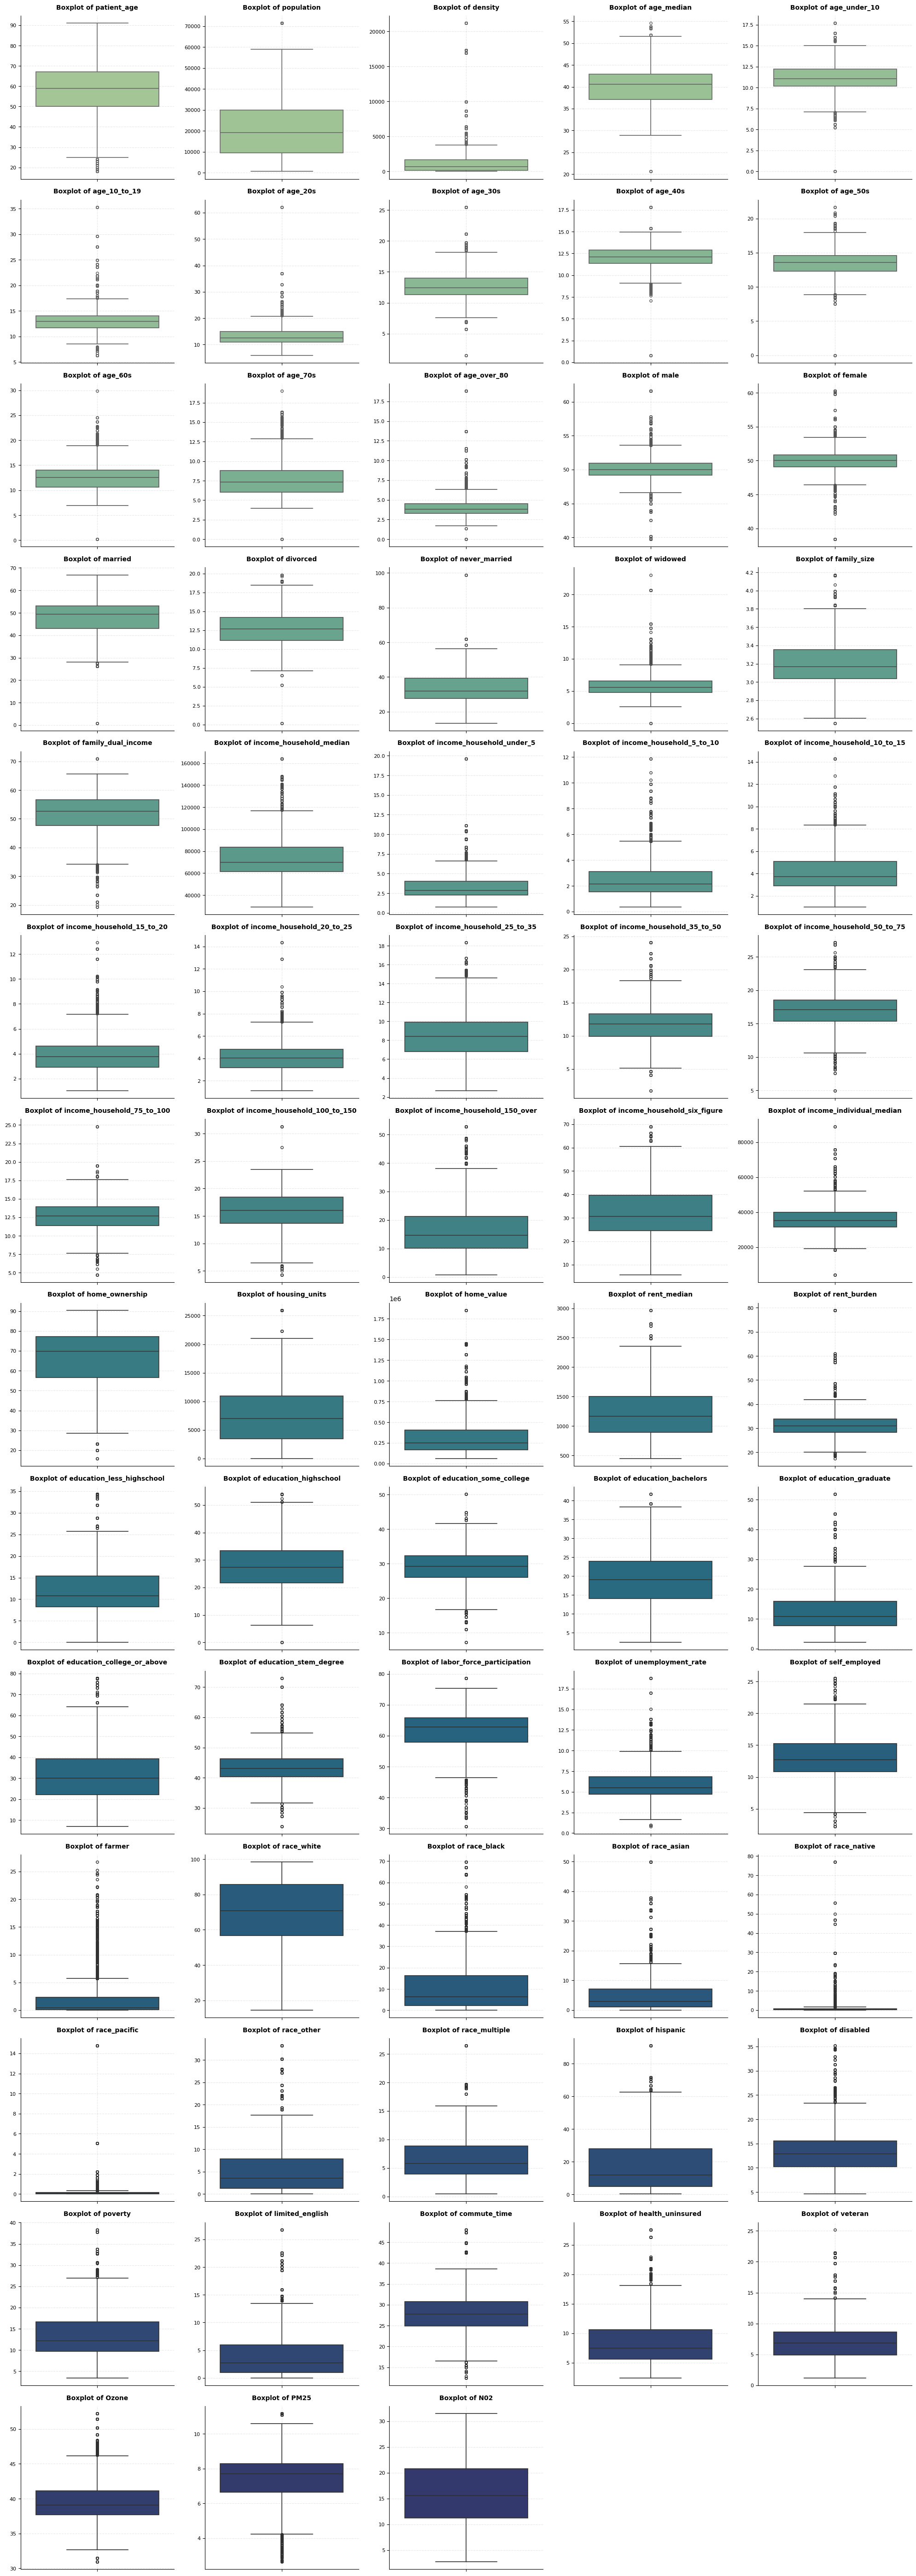

In [55]:
n_plots = len(gradient_cols)
colors_crest = sns.color_palette("crest", n_colors=n_plots)

fig, axes = plt.subplots(15, 5, figsize=(20, 60))
axes = axes.flatten()

for i, col in enumerate(gradient_cols):
    if i < len(axes):
        sns.boxplot(data=train, y=col, ax=axes[i], 
                   color=colors_crest[i], 
                   saturation=0.8,
                   linewidth=1.2,
                   flierprops={'markersize': 4})
        
        axes[i].set_title(f'Boxplot of {col}', fontsize=10, pad=10, weight='bold')
        axes[i].set_ylabel('')
        axes[i].grid(True, alpha=0.3, linestyle='--')
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

for j in range(len(gradient_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Heatmap


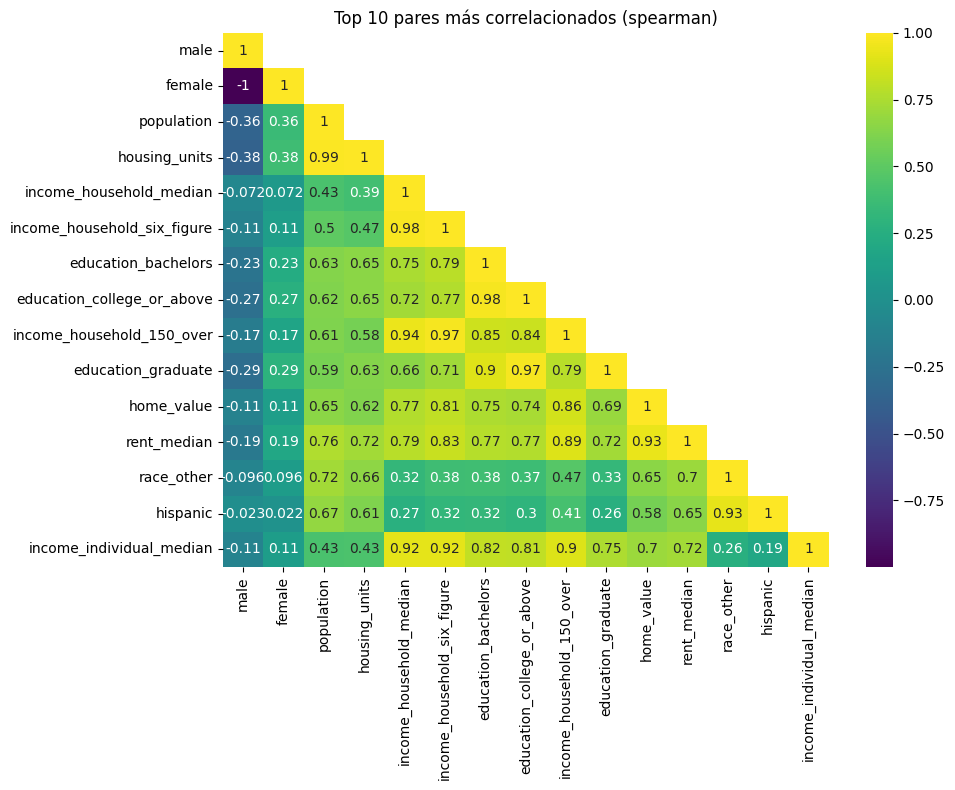

,Var1,Var2,Corr
0,male,female,0.999998
1,population,housing_units,0.986826
2,income_household_median,income_household_six_figure,0.981750
3,education_bachelors,education_college_or_above,0.975949
4,income_household_150_over,income_household_six_figure,0.971521
5,education_graduate,education_college_or_above,0.970372
6,income_household_median,income_household_150_over,0.939490
7,home_value,rent_median,0.934812
8,race_other,hispanic,0.927293
9,income_household_median,income_individual_median,0.917055


In [67]:
hex("\033[1mHeatmap\033[22m", "#5F9EA0")

def top_corr_heatmap(data, columns, top_n=10, method='spearman'):
    corr = data[columns].corr(method=method).abs()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    upper = corr.where(mask)
    
    top_pairs = (
        upper.stack()
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
        .rename(columns={'level_0': 'Var1', 'level_1': 'Var2', 0: 'Corr'})
    )
    
    top_vars = pd.unique(top_pairs[['Var1', 'Var2']].values.ravel())
    
    subset_corr = data[top_vars].corr(method=method)
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones(subset_corr.shape), k=1)
    sns.heatmap(subset_corr, mask=mask, annot=True, cmap='viridis')
    plt.title(f'Top {top_n} pares más correlacionados ({method})')
    plt.tight_layout()
    plt.show()
    
    return top_pairs

top_corr_heatmap(train, gradient_cols)

Dashboard: distribución de pacientes y tipo de seguro por raza


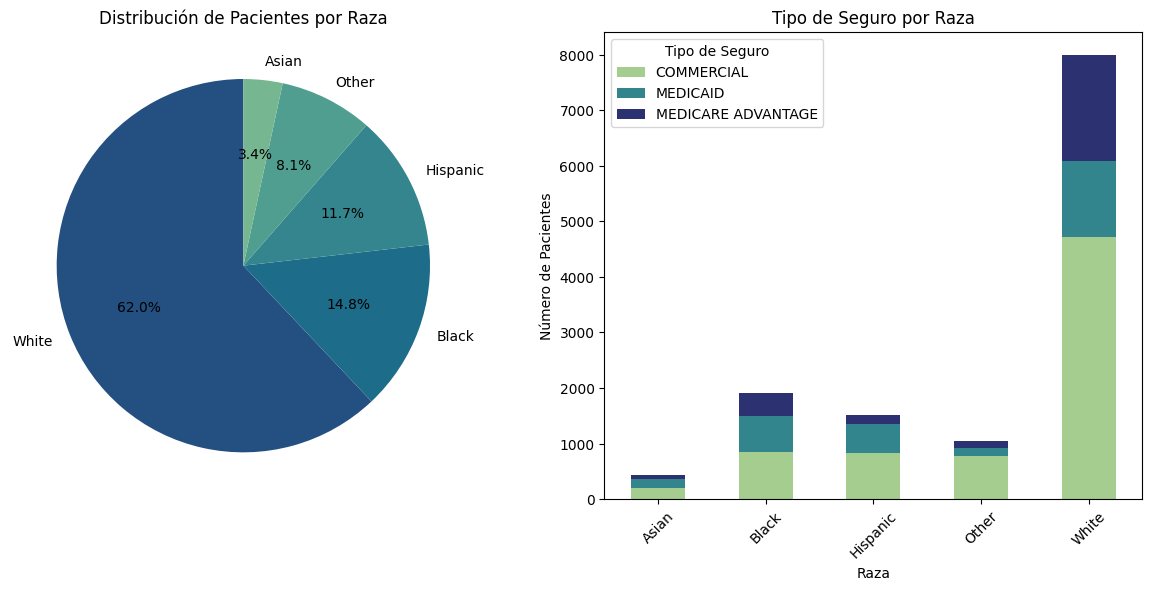

In [68]:
hex("\033[1mDashboard: distribución de pacientes y tipo de seguro por raza\033[22m", "#5F9EA0")

def plot_demographics():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    race_counts = train['patient_race'].value_counts()
    colors_crest = sns.color_palette("crest_r", n_colors=len(race_counts))
    axes[0].pie(race_counts, labels=race_counts.index, autopct='%1.1f%%',
                startangle=90, colors=colors_crest)
    axes[0].set_title('Distribución de Pacientes por Raza')
    
    crosstab = pd.crosstab(train['patient_race'], train['payer_type'])
    crosstab.plot(kind='bar', stacked=True, ax=axes[1], colormap='crest')
    axes[1].set_title('Tipo de Seguro por Raza')
    axes[1].set_xlabel('Raza')
    axes[1].set_ylabel('Número de Pacientes')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Tipo de Seguro')
    
    plt.tight_layout()
    plt.show()

plot_demographics()

<span style="color:#AFEEEE; font-size: 22px; font-style: italic;">Versión alternativa</span>

Top 5 ZIP con mayor cantidad de pacientes:
     patient_zip3  patient_count
653           900            239
10            112            192
668           917            170
439           606            150
566           770            132


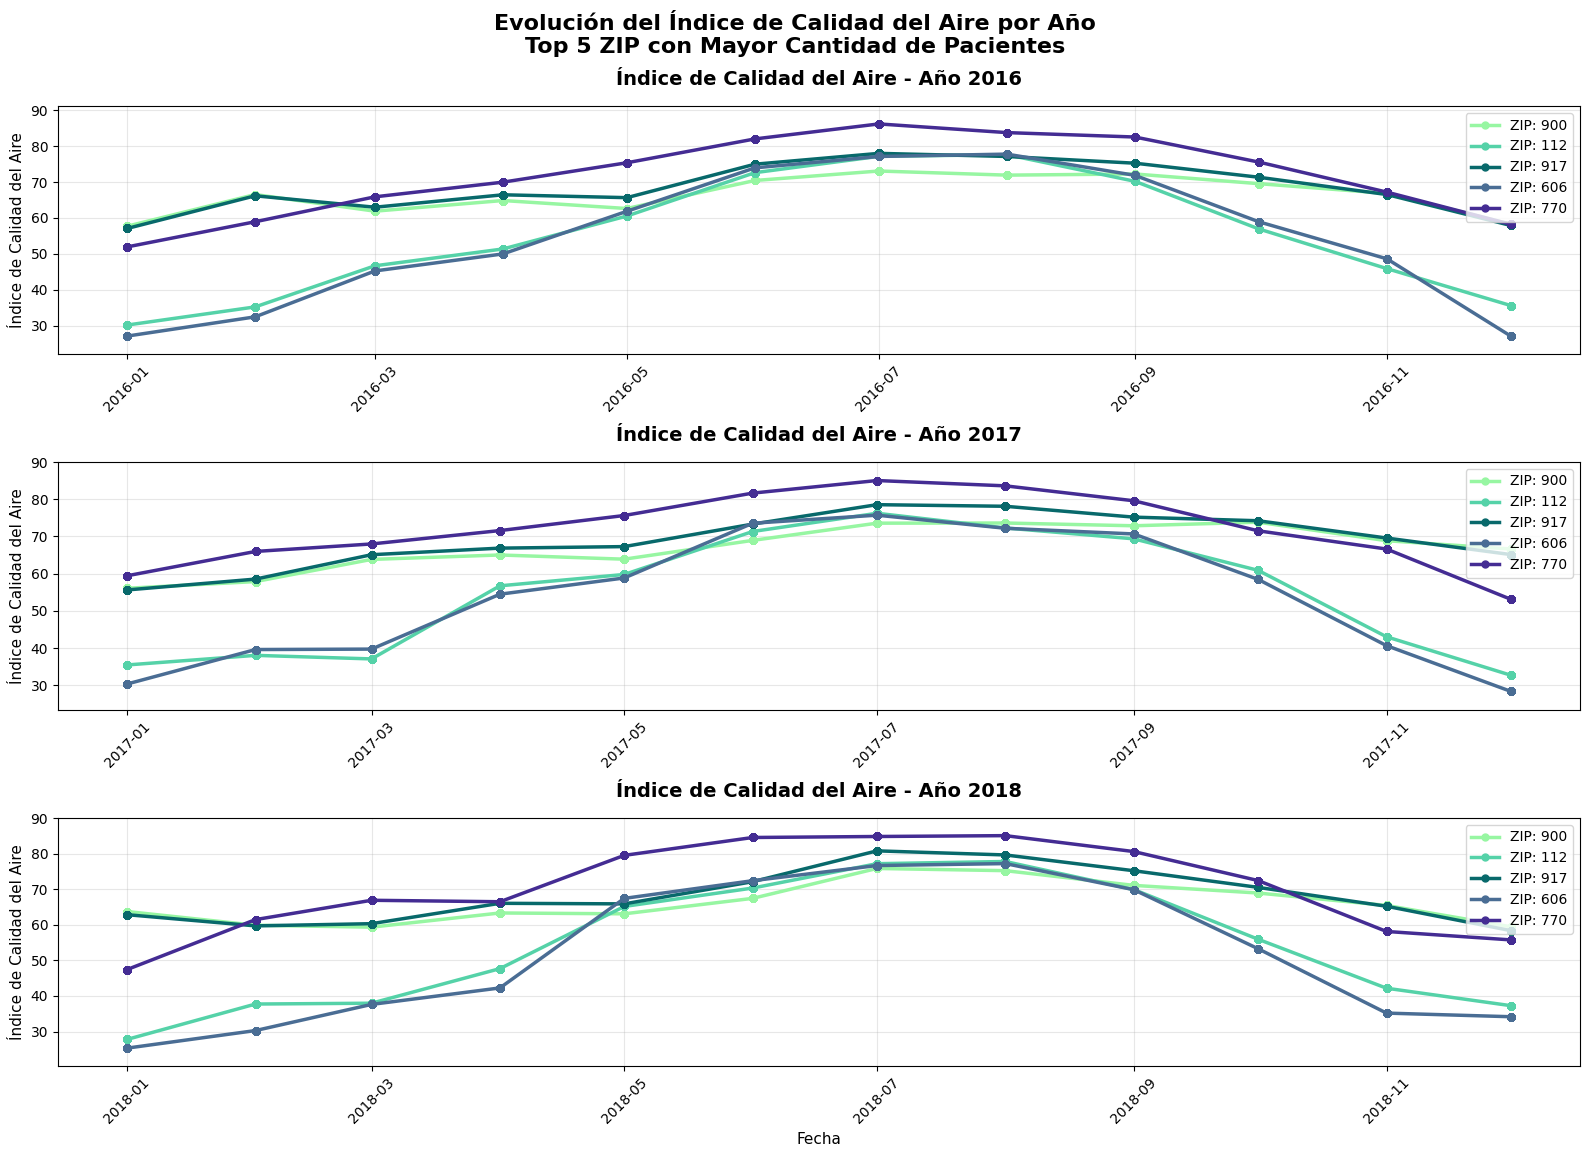

In [69]:
train_alt_zip = train_alt.iloc[:,[0]+[4]+list(range(80,151))]
train_zip_code = train_zip_code.drop_duplicates()

# Top 5 patient_zip3 con mayor cantidad de pacientes
patient_counts = train.groupby('patient_zip3')['patient_id'].nunique().reset_index()
patient_counts.columns = ['patient_zip3', 'patient_count']
patient_counts = patient_counts.sort_values('patient_count', ascending=False)
top_5_zip3 = patient_counts.head(5)['patient_zip3'].tolist()

print("Top 5 ZIP con mayor cantidad de pacientes:")
print(patient_counts.head(5))

# Filtrado de train_alt_zip para los top 5 ZIP
air_quality_data = train_alt_zip[train_alt_zip['patient_zip3'].isin(top_5_zip3)].copy()

# Seleccionar las columnas de fechas
date_columns = air_quality_data.columns[2:]

# Diccionario para mapear nombres de columnas a fechas
def parse_date_column(col_name):
    try:
        # Ejemplo: "Average of Jan-17" -> "2017-01"
        if "Average of" in col_name:
            date_part = col_name.replace("Average of ", "")
            month_year = date_part.split("-")
            if len(month_year) == 2:
                month_map = {
                    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
                    'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
                    'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
                }
                month = month_map.get(month_year[0], '01')
                year = '20' + month_year[1] if len(month_year[1]) == 2 else month_year[1]
                return f"{year}-{month}-01"
    except:
        pass
    return None

# Visualización
melted_data = []

for _, row in air_quality_data.iterrows():
    zip3 = row['patient_zip3']
    for col in date_columns:
        date_str = parse_date_column(col)
        if date_str and not pd.isna(row[col]):
            melted_data.append({
                'patient_zip3': zip3,
                'date': pd.to_datetime(date_str),
                'air_quality_index': row[col],
                'original_column': col
            })

timeline_df = pd.DataFrame(melted_data)

if len(timeline_df) > 0:
    # Filtrar datos para 2016-2018
    timeline_filtered = timeline_df[timeline_df['date'].dt.year.isin([2016, 2017, 2018])].copy()
    
    if len(timeline_filtered) > 0:
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))
        colors = ["#97f6a2", "#55d2a8", "#08696B", '#4a6d94', "#442C93"]
        zip_colors = dict(zip(top_5_zip3, colors))
        
        years = [2016, 2017, 2018]
        
        for i, year in enumerate(years):
            ax = axes[i]
            year_data = timeline_filtered[timeline_filtered['date'].dt.year == year]
            
            for zip3 in top_5_zip3:
                zip_data = year_data[year_data['patient_zip3'] == zip3].sort_values('date')
                if len(zip_data) > 0:
                    ax.plot(zip_data['date'], zip_data['air_quality_index'], 
                           marker='o', label=f'ZIP: {zip3}', linewidth=2.5, 
                           markersize=5, color=zip_colors[zip3])
            
            ax.set_title(f'Índice de Calidad del Aire - Año {year}', 
                        fontsize=14, fontweight='bold', pad=15)
            ax.set_ylabel('Índice de Calidad del Aire', fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=10)
            
            ax.tick_params(axis='x', rotation=45)
            
            if len(year_data) > 0:
                y_min = year_data['air_quality_index'].min() - 5
                y_max = year_data['air_quality_index'].max() + 5
                ax.set_ylim(y_min, y_max)
        
        axes[2].set_xlabel('Fecha', fontsize=11)
        
        # Título general
        fig.suptitle('Evolución del Índice de Calidad del Aire por Año\nTop 5 ZIP con Mayor Cantidad de Pacientes', 
                     fontsize=16, fontweight='bold', y=0.96)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()
        
    else:
        print("No hay datos disponibles para el período 2017-2019")
        print("Años disponibles en los datos:")
        print(timeline_df['date'].dt.year.value_counts().sort_index())
    
else:
    print("Columnas disponibles en train_alt_zip:")
    print(list(air_quality_data.columns))
    print("\nPrimeras filas de air_quality_data:")
    print(air_quality_data.head())

<span style="color:#00CED1; font-size: 24px; font-weight: bold;">Preprocesamiento del dataset nuevo test</span>

In [ ]:
from sklearn.model_selection import train_test_split

# Paso 1: Separar 70% train y 30% (validación + test interno)
train_clean, temp_clean = train_test_split(
    train, 
    test_size=0.30, 
    stratify=train['DiagPeriodL90D'], 
    random_state=123
)

# Paso 2: Separar 15% validación y 15% test interno desde ese 30%
valid_clean, test_clean = train_test_split(
    temp_clean, 
    test_size=0.50, 
    stratify=temp_clean['DiagPeriodL90D'], 
    random_state=123
)

# Confirmar tamaños
print(f"Train set: {train_clean.shape}")
print(f"Validation set: {valid_clean.shape}")
print(f"Test interno set: {test_clean.shape}")

#train_clean.to_csv('train_clean.csv', index=False)
#valid_clean.to_csv('valid_clean.csv', index=False)
#test_clean.to_csv('test_clean.csv', index=False)

Train set: (9034, 78)
Validation set: (1936, 78)
Test interno set: (1936, 78)
